In [1]:
import tensorflow as tf
print(tf.__version__)

2024-04-29 04:41:04.249041: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-29 04:41:04.299925: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-29 04:41:06.649193: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.0


In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

In [3]:
vggish_model_handle = 'https://www.kaggle.com/models/google/vggish/frameworks/TensorFlow2/variations/vggish/versions/1'
vggish_model = hub.load(vggish_model_handle)

2024-04-29 04:41:28.507115: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-29 04:41:28.508897: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
import librosa
# Utility functions to load audio files and make sure the sample rate is correct.
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    y, sr = librosa.load(filename, sr=16000, mono=True) # y = audio time series
    return y

In [5]:
files_csv = './dataset_metadata.csv'

pd_data = pd.read_csv(files_csv)
pd_data.head()

,filename,emotion,target
0,/run/media/rodrigo/Data SSD (2TB)/Unifei/Compu...,neutral,0
1,/run/media/rodrigo/Data SSD (2TB)/Unifei/Compu...,neutral,0
2,/run/media/rodrigo/Data SSD (2TB)/Unifei/Compu...,neutral,0
3,/run/media/rodrigo/Data SSD (2TB)/Unifei/Compu...,neutral,0
4,/run/media/rodrigo/Data SSD (2TB)/Unifei/Compu...,neutral,0


In [6]:
#my_classes = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgusted', 'surprised']
my_classes = ['Neutra', 'Calma', 'Felicidade', 'Tristeza', 'Raiva', 'Medo', 'Surpresa', 'Nojo']

In [7]:
filenames = pd_data['filename']
targets = pd_data['target']
emotions = pd_data['emotion']
dataset = []
dataset_tf = []

for f in filenames:
    wav = np.array(load_wav_16k_mono(f))
    dataset.append(wav)
    dataset_tf.append(wav)

In [8]:
highest_audio_length = len(max(dataset, key=len))

# Padding audios shorter than the highest audio length with 0's to normalize and allow passing through models
for index, audio_file in enumerate(dataset):
    if len(audio_file) < highest_audio_length:
        dataset[index] = librosa.util.pad_center(audio_file, size=highest_audio_length, mode='constant')

In [ ]:
# Applies the embedding extraction model to a wav data and return the extracted features/embeddings
def extract_embedding(wav_data):
  ''' run YAMNet to extract embedding from the wav data '''
  embeddings = vggish_model(wav_data)
  
  return embeddings

# https://groups.google.com/g/audioset-users/c/h6ijY4RZjfY
# The embedding extraction returns a 128-D tensor for each 0,96 sec of audio. Need to flatten the embeddings to pass through classifiers
# The embeddings tensor will be a Tensor with N positions (1 position for each 0,96 sec), where each position is the 128-D tensor
# Generating an embedding to get its shape, and latter flatten (reshape) the tensors with the correct dimmensions
embeddings_shape = vggish_model(dataset[0]).shape
number_of_tensors = embeddings_shape[0]
embeddings_length = embeddings_shape[1]
flattened_dimmension = number_of_tensors * embeddings_length

# Extract embeddings
for index, wav_file in enumerate(dataset):
    embeddings = extract_embedding(wav_file)
    flattened_tensor = tf.reshape(embeddings, [flattened_dimmension])
    numpy_array = flattened_tensor.numpy()
    dataset[index] = numpy_array

In [ ]:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

kf = KFold(n_splits=5, shuffle=True, random_state=42)
X = dataset.copy()
Y = targets.copy()

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm

pipe = Pipeline(steps=[('scaler', StandardScaler()), ('svm', svm.SVC())])

In [ ]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
scores = cross_val_score(pipe, X, Y, cv=kf)

y_pred = cross_val_predict(pipe, X, Y, cv=kf)

Fold 1: Score = 0.5729
Fold 2: Score = 0.4653
Fold 3: Score = 0.5104
Fold 4: Score = 0.5139
Fold 5: Score = 0.5660
Average Score: 0.5257 +- 0.0397
              precision    recall  f1-score   support

           0       0.42      0.34      0.38        96
           1       0.62      0.69      0.65       192
           2       0.39      0.32      0.35       192
           3       0.42      0.37      0.39       192
           4       0.60      0.59      0.60       192
           5       0.55      0.43      0.48       192
           6       0.53      0.64      0.58       192
           7       0.57      0.73      0.64       192

    accuracy                           0.53      1440
   macro avg       0.51      0.51      0.51      1440
weighted avg       0.52      0.53      0.52      1440



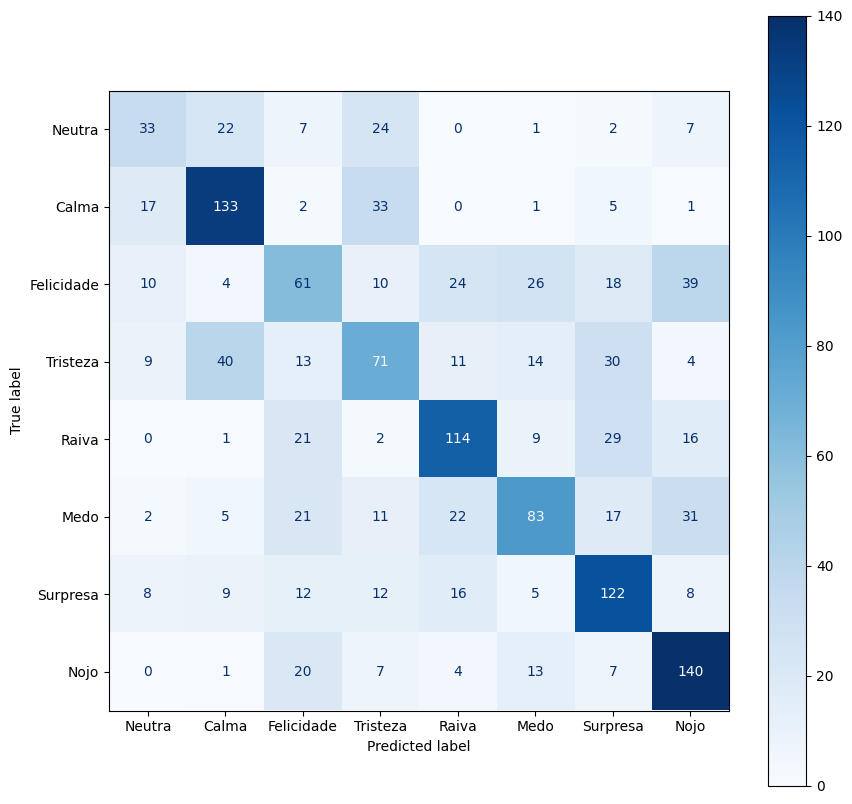

In [13]:
for fold_index, score in enumerate(scores):
    print(f"Fold {fold_index + 1}: Score = {score:.4f}")
print(f"Average Score: {np.mean(scores):.4f} +- {np.std(scores):.4f}")

print(metrics.classification_report(Y, y_pred))

_, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(Y, y_pred, cmap='Blues', display_labels=my_classes, ax=ax)

Fold 1: Score = 0.5069
Fold 2: Score = 0.4236
Fold 3: Score = 0.5312
Fold 4: Score = 0.4792
Fold 5: Score = 0.5243
Average Score: 0.4931 +- 0.0391
              precision    recall  f1-score   support

           0       0.40      0.24      0.30        96
           1       0.52      0.77      0.62       192
           2       0.34      0.31      0.32       192
           3       0.36      0.24      0.29       192
           4       0.62      0.60      0.61       192
           5       0.50      0.44      0.47       192
           6       0.45      0.49      0.47       192
           7       0.55      0.66      0.60       192

    accuracy                           0.48      1440
   macro avg       0.47      0.47      0.46      1440
weighted avg       0.47      0.48      0.47      1440



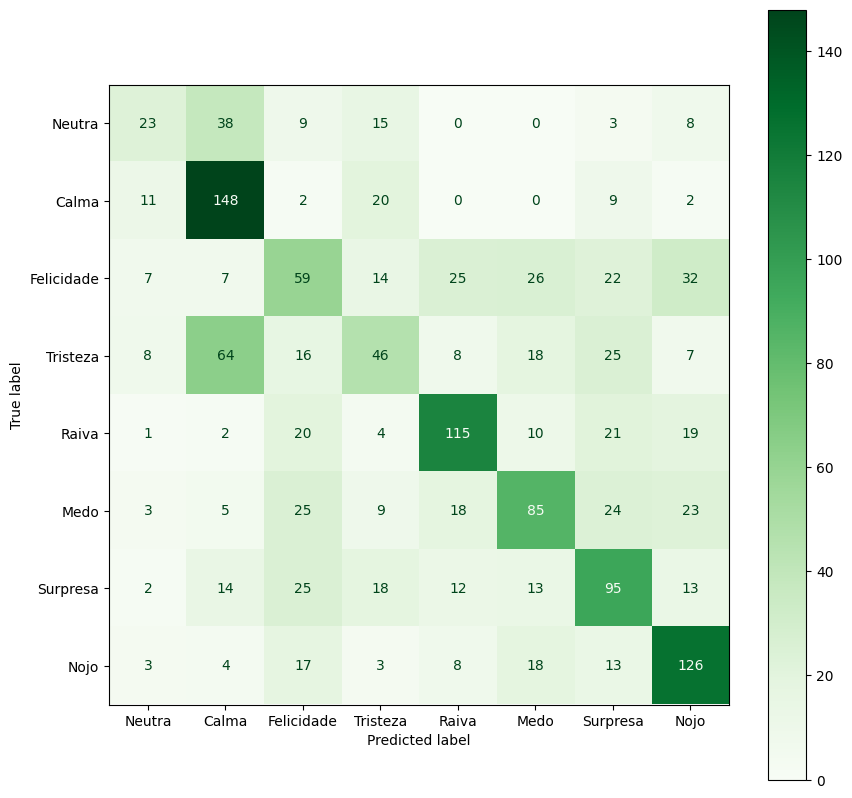

In [14]:
#SCIKIT Random Forest

from sklearn.ensemble import RandomForestClassifier

pipe_forest = Pipeline(steps=[('scaler', StandardScaler()), ('forest', RandomForestClassifier())])

scores_forest = cross_val_score(pipe_forest, X, Y, cv=kf)

y_pred_forest = cross_val_predict(pipe_forest, X, Y, cv=kf)

for fold_index, score in enumerate(scores_forest):
    print(f"Fold {fold_index + 1}: Score = {score:.4f}")
print(f"Average Score: {np.mean(scores_forest):.4f} +- {np.std(scores_forest):.4f}")

print(metrics.classification_report(Y, y_pred_forest))

_, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(Y, y_pred_forest, cmap='Greens', display_labels=my_classes, ax=ax)

Fold 1: Score = 0.2569
Fold 2: Score = 0.2257
Fold 3: Score = 0.2743
Fold 4: Score = 0.2743
Fold 5: Score = 0.2396
Average Score: 0.2542 +- 0.0192
              precision    recall  f1-score   support

           0       0.16      0.91      0.27        96
           1       0.39      0.08      0.13       192
           2       0.31      0.05      0.08       192
           3       0.12      0.02      0.03       192
           4       0.35      0.25      0.29       192
           5       0.42      0.15      0.22       192
           6       0.38      0.28      0.32       192
           7       0.28      0.64      0.38       192

    accuracy                           0.25      1440
   macro avg       0.30      0.29      0.21      1440
weighted avg       0.31      0.25      0.21      1440



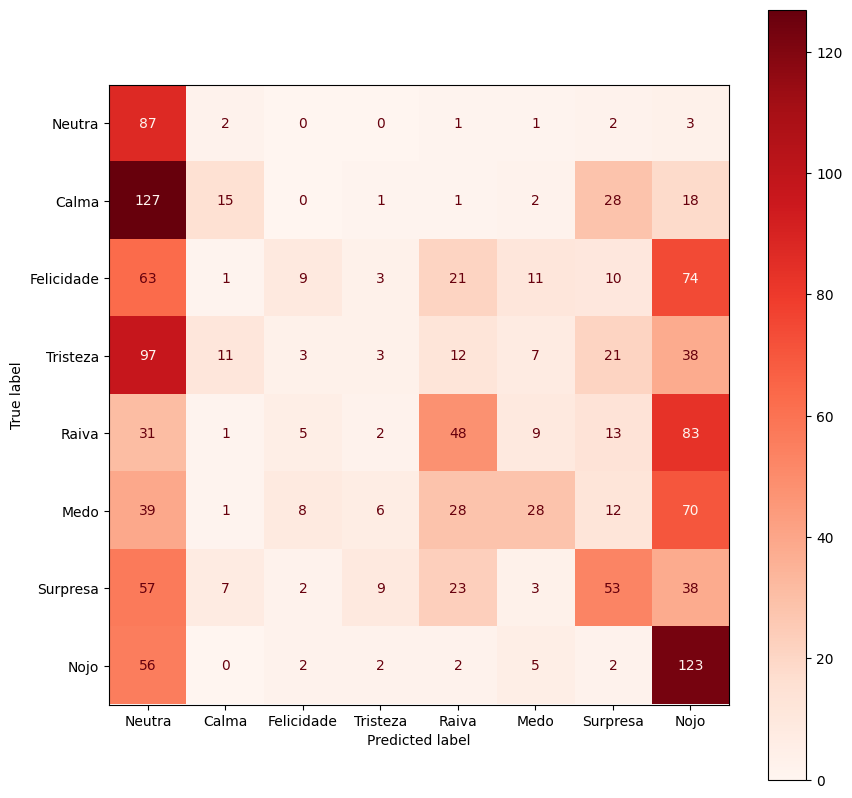

In [15]:
# SVM Naive Bayes
from sklearn.naive_bayes import GaussianNB

pipe_naive_bayes = Pipeline(steps=[('scaler', StandardScaler()), ('naive', GaussianNB() )])

scores_naive_bayes = cross_val_score(pipe_naive_bayes, X, Y, cv=kf)

y_pred_naive_bayes = cross_val_predict(GaussianNB(), X, Y, cv=kf)
y_pred_naive_bayes = cross_val_predict(pipe_naive_bayes, X, Y, cv=kf)

for fold_index, score in enumerate(scores_naive_bayes):
    print(f"Fold {fold_index + 1}: Score = {score:.4f}")
print(f"Average Score: {np.mean(scores_naive_bayes):.4f} +- {np.std(scores_naive_bayes):.4f}")

print(metrics.classification_report(Y, y_pred_naive_bayes))

_, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(Y, y_pred_naive_bayes, cmap='Reds', display_labels=my_classes, ax=ax)

In [17]:
# Neural network using Tensorflow
dataset_numpy = np.array(dataset)
targets_numpy = np.array(targets)

y_true = np.array([], np.int32)
y_pred = np.array([], np.int32)

fold_index = 1
scores_neural_network = np.array([])

for train_indexes, test_indexes in kf.split(dataset_numpy, targets_numpy):
    train_ds = np.array(dataset_numpy[train_indexes])
    train_labels = np.array(targets_numpy[train_indexes])
    
    test_ds = np.array(dataset_numpy[test_indexes])
    test_labels = np.array(targets_numpy[test_indexes])
    
    history = my_model.fit(x=train_ds, y=train_labels,
                       epochs=150,
                       #validation_data=validation_ds,
                       #validation_split=0.25,
                       callbacks=callback,
                       verbose=0)

    loss, accuracy = my_model.evaluate(test_ds, test_labels, verbose=0)
   
    #print("Loss: ", loss)
    print(f"Fold {fold_index }: Score = {accuracy:.4f}")  
    
    # Adding true labels and predicted labels to their respective arrays
    y_true = np.concatenate((y_true, test_labels))
    
    fold_predictions = my_model.predict(test_ds, verbose=0).argmax(axis=1)
    y_pred = np.concatenate((y_pred, fold_predictions))

    # Adding accuracy to array
    scores_neural_network = np.append(scores_neural_network, [accuracy])

    fold_index += 1
    print()

print(f"\n\nAverage Score: {np.mean(scores_neural_network):.4f} +- {np.std(scores_neural_network):.4f}")
print(metrics.classification_report(y_true, y_pred))

Fold 1: Score = 0.6285

Fold 2: Score = 0.8646

Fold 3: Score = 1.0000

Fold 4: Score = 0.9965

Fold 5: Score = 1.0000



Average Score: 0.8979 +- 0.1444
              precision    recall  f1-score   support

           0       0.88      0.89      0.88        96
           1       0.93      0.94      0.94       192
           2       0.86      0.86      0.86       192
           3       0.89      0.81      0.84       192
           4       0.96      0.93      0.94       192
           5       0.87      0.91      0.89       192
           6       0.88      0.91      0.89       192
           7       0.92      0.93      0.92       192

    accuracy                           0.90      1440
   macro avg       0.90      0.90      0.90      1440
weighted avg       0.90      0.90      0.90      1440



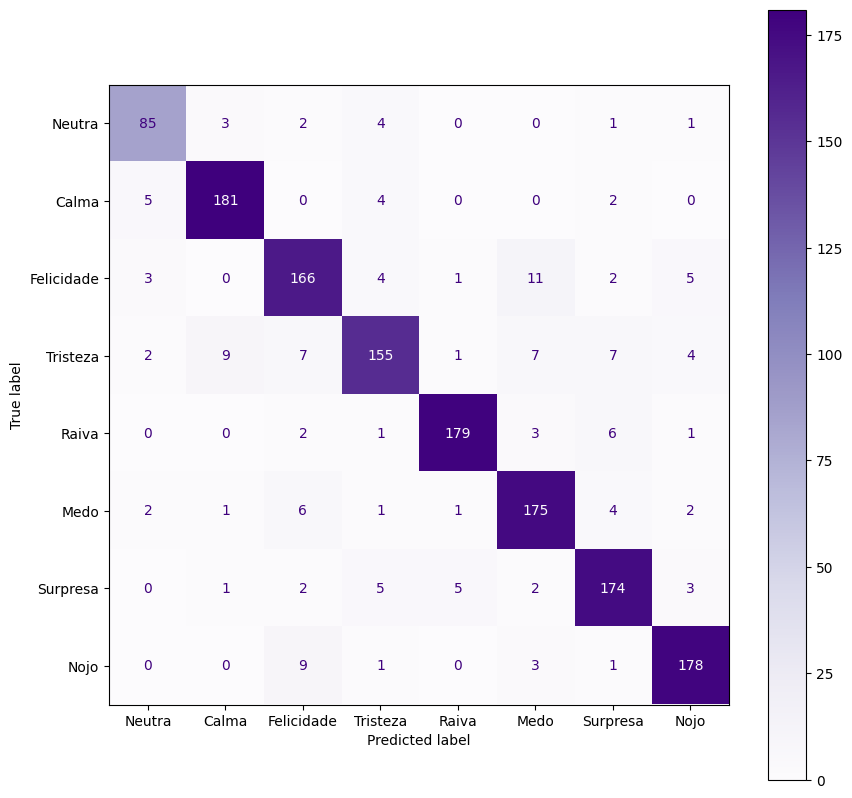

In [18]:
_, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap='Purples', display_labels=my_classes, ax=ax)